# Лабораторная работа 3.15
<font size="4"> Проект
    
<font size="4">Обзор функций, которые используются в проекте

In [42]:
import cv2
import numpy as np
import random
import imutils
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans

<font size="4">На первом этапе проводится предварительная обработка изображений, которая включает в себя удаление шума, повышение резкости изображений. С помощью этой обработки выделяются характерные детали, подавляется шум, повышается быстродействие, уменьшается объем информации

In [43]:
image = cv2.imread('tiger.jpg')

In [44]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [45]:
denoised = cv2.GaussianBlur(gray, (5, 5), 0)

sharpness = cv2.filter2D(denoised, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))

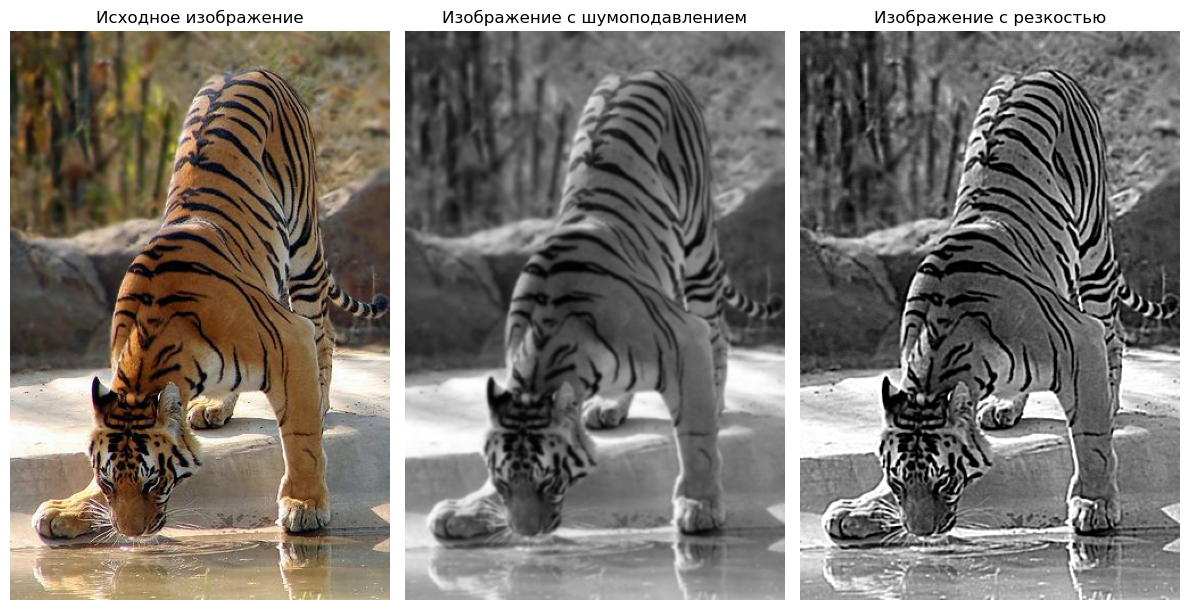

In [46]:
plt.figure(figsize=(12, 8))

plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(132)
plt.imshow(denoised, cmap='gray')
plt.title('Изображение с шумоподавлением')
plt.axis('off')

plt.subplot(133)
plt.imshow(sharpness, cmap='gray')
plt.title('Изображение с резкостью')
plt.axis('off')

plt.tight_layout()
plt.show();

<font size="4">Следующий шаг – удалении фона на изображении, для этого 
сканируется все пространство изображения и отсканированные пиксели с одинаковой интенсивностью обнуляются. В результате интересующие нас объекты будут более четко выделены на черном фоне.
Функция def shelf () предназначена для удаления фона. 

In [47]:
def shelf(image_path):
    image = cv2.imread(image_path)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    
    result = cv2.bitwise_and(image, image, mask=mask)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Исходное изображение'), plt.axis('off')
    plt.subplot(122), plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)), plt.title('Изображение без фона'), plt.axis('off')
    plt.show();

In [48]:
image_path = 'tiger.jpg'

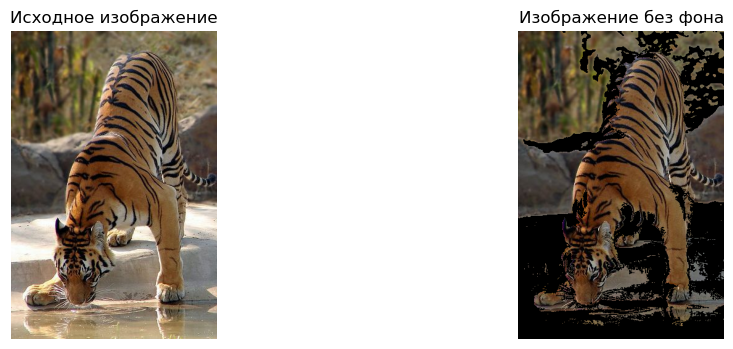

In [49]:
shelf(image_path)

<font size="4">Для выделения объектов используется операция сегментации 
изображения методом водораздела, с последующей маркировкой результата сегментации. Функция segment() предназначена 
для разбиения всего поля изображения на сегменты.

In [50]:
def segment(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    im_bw = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)[1]
    plt.imshow(im_bw, cmap='gray'), plt.axis('off'), plt.title('Пороговое преобразование'), plt.show()
    
    kernel = np.ones((4, 3), np.uint8)
    opening = cv2.morphologyEx(im_bw, cv2.MORPH_OPEN, kernel, iterations=1)
    
    sure_bg = cv2.dilate(opening, kernel, iterations=1)
    
    dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 3)
    ret, sure_fg = cv2.threshold(dist_transform, 0.01 * dist_transform.max(), 255, cv2.THRESH_BINARY)
    sure_fg = np.uint8(sure_fg)
    
    unknown = cv2.Canny(sure_bg, 700, 100, apertureSize=3)
    plt.imshow(unknown, cmap='gray'), plt.title('Canny преобразование'), plt.axis('off'), plt.show()
    
    ret, mark = cv2.connectedComponents(sure_fg)
    mark = mark + 1
    mark[unknown]
    
    markers = cv2.watershed(img, mark)
    
    img[markers == -1] = [255, 0, 0]
    
    return img

In [51]:
imgor = cv2.imread('shlf.jpg')

In [52]:
img = cv2.resize(imgor, (800, 800))

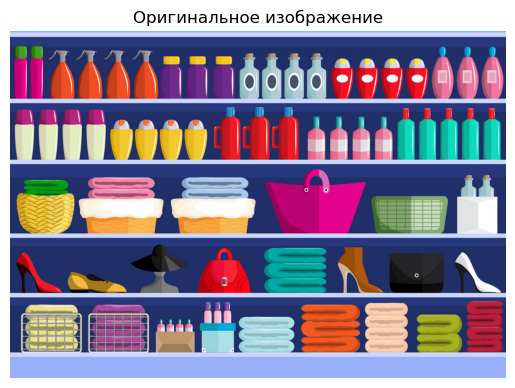

In [53]:
plt.imshow(cv2.cvtColor(imgor, cv2.COLOR_BGR2RGB))
plt.title('Оригинальное изображение')
plt.axis('off')
plt.show();

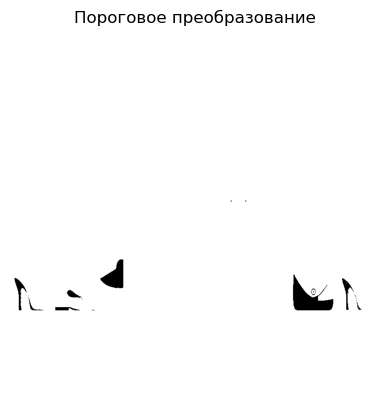

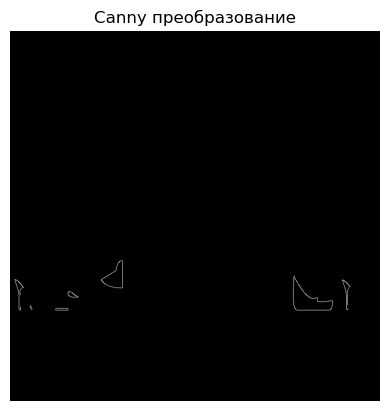

In [54]:
marker = segment(img)

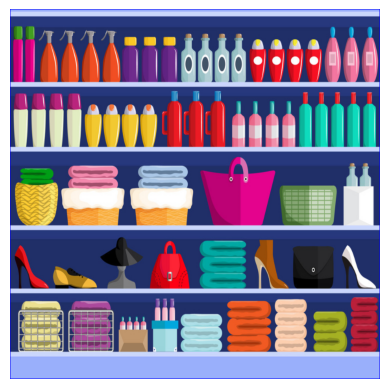

In [55]:
plt.imshow(cv2.cvtColor(marker, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show();

<font size="4">С помощью операции распознавания объекта по шаблону каждый объект охватывается прямоугольной рамкой.
Распознавание объекта по шаблону. Метод заключается в поиске 
объекта на большом изображении, который соответствует выбранному шаблону.

In [56]:
def match_template(image_path, template_path):
    image = cv2.imread(image_path)
    template = cv2.imread(template_path)
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    result = cv2.matchTemplate(gray_image, gray_template, cv2.TM_CCOEFF_NORMED)
    
    threshold = 0.8
    loc = np.where(result >= threshold)
    
    for pt in zip(*loc[::-1]):
        cv2.rectangle(image, pt, (pt[0] + template.shape[1], pt[1] + template.shape[0]), (0, 255, 0), 2)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
    plt.title('Шаблон')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))   
    plt.title('Распознавание объекта по шаблону')
    plt.axis('off')
    plt.show();

In [57]:
image_path = 'shlf.jpg'
template_path = 'shlf2.jpg'

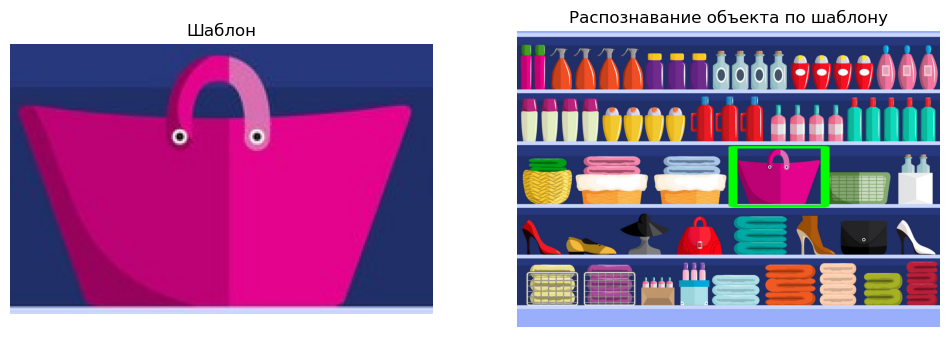

In [58]:
match_template(image_path, template_path)

## Создание таблицы признаков

<font size="4">На основе массива точек изображения и массива координат контура вычисляются все признаки объекта

In [59]:
img = cv2.imread('shlf.jpg', 0)

In [60]:
th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

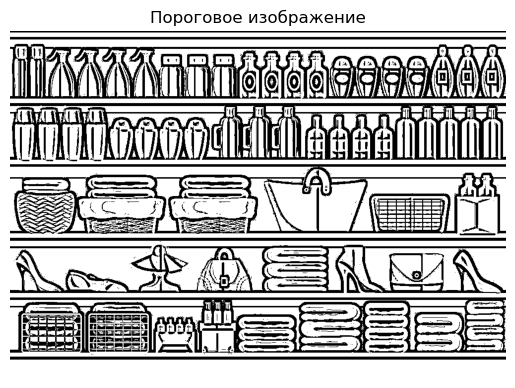

In [61]:
plt.imshow(th, cmap='gray')
plt.title('Пороговое изображение')
plt.axis('off')
plt.show()

In [62]:
contours, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[0]

area = cv2.contourArea(cnt)
perimeter = cv2.arcLength(cnt, True)
hull = cv2.convexHull(cnt)

x, y, w, h = cv2.boundingRect(cnt)

image_with_rectangle = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

In [63]:
print("Координата x:", x)
print("Координата y:", y)
print("Ширина прямоугольника:", w)
print("Высота прямоугольника:", h)

Координата x: 0
Координата y: 663
Ширина прямоугольника: 1000
Высота прямоугольника: 37


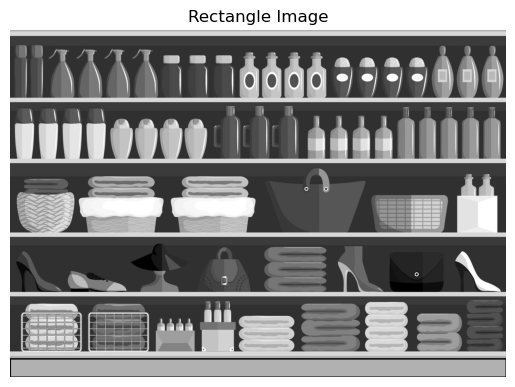

In [64]:
imag = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(imag, cmap='gray')
plt.title('Rectangle Image')
plt.axis('off')
plt.show();

In [65]:
epsilon = 0.1 * cv2.arcLength(cnt, True)
aspect_ratio = float(w) / h
rect_area = w * h
extent = float(area) / rect_area
hull_area = cv2.contourArea(hull)
equi_diameter = np.sqrt(4 * area / np.pi)

In [66]:
mask = np.zeros(img.shape, np.uint8)
cv2.drawContours(mask, [cnt], 0, 255, -1);

In [67]:
M = cv2.moments(cnt)

pixelpoints = np.transpose(np.nonzero(mask))
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(img, mask=mask)

In [68]:
leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])
rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])
topmost = tuple(cnt[cnt[:, :, 1].argmin()][0])
bottommost = tuple(cnt[cnt[:, :, 1].argmax()][0])

In [69]:
print("Площадь:", area)
print("Периметр:", perimeter)
print("Ширина, Высота:", w, h)
print("Соотношение сторон:", aspect_ratio)
print("Отношение площади к ограничивающему прямоугольнику:", extent)
print("Площадь выпуклой оболочки:", hull_area)
print("Эквивалентный диаметр:", equi_diameter)
print("Моменты:", M)
print("Самая левая точка:", leftmost)
print("Самая правая точка:", rightmost)
print("Самая верхняя точка:", topmost)
print("Самая нижняя точка:", bottommost)

Площадь: 35964.0
Периметр: 2070.0
Ширина, Высота: 1000 37
Соотношение сторон: 27.027027027027028
Отношение площади к ограничивающему прямоугольнику: 0.972
Площадь выпуклой оболочки: 35964.0
Эквивалентный диаметр: 213.9878197161123
Моменты: {'m00': 35964.0, 'm10': 17964018.0, 'm01': 24491484.0, 'm20': 11964035988.0, 'm11': 12233496258.0, 'm02': 16682584716.0, 'm30': 8964053964009.0, 'm21': 8147508507828.0, 'm12': 8332951065642.0, 'm03': 11366130352140.0, 'mu20': 2991008997.0, 'mu11': 0.0, 'mu02': 3884112.0, 'mu30': 0.0, 'mu21': 0.0, 'mu12': 0.0, 'mu03': 0.0, 'nu20': 2.3125, 'nu11': 0.0, 'nu02': 0.003003003003003003, 'nu30': 0.0, 'nu21': 0.0, 'nu12': 0.0, 'nu03': 0.0}
Самая левая точка: (0, 663)
Самая правая точка: (999, 699)
Самая верхняя точка: (0, 663)
Самая нижняя точка: (0, 699)


## Распознавание объектов с помощью нейронной сети

<font size="4">Алгоритм распознавания объектов.
1. По вычисленным признакам всех объектов проводится обучение нейросети, т. е. для каждого объекта по его признакам определяется значение на выходе нейросети и заносится в последнюю 
строку таблицы. Таким образом каждому объекту сопоставляется 
маркер.
2. Сравнение данных из базы признаков с признаками неизвестного объекта позволяет распознать этот объект и определить его маркер.

In [70]:
s = [1249.0, 577.0, 180.5, 7795.5, 163.0, 111.0, 909.5, 29.5]
p = [157.55, 141.34, 90.476, 1262.1, 61.799, 78.064, 175.47, 48.730]
w = [31, 51, 7, 66, 15, 5, 24, 5]
h = [54, 26, 41, 158, 22, 37, 70, 22]
kw = [0.574, 1.9615, 0.1707, 0.4177, 0.6818, 0.1351, 0.3429, 0.2272]
ks = [0.7461, 0.4351, 0.6289, 0.7475, 0.4939, 0.6, 0.5414, 0.2682]
d = [39.878, 27.105, 15.160, 99.627, 14.406, 11.888, 34.029, 6.1287]
m0 = [1249.0, 577.0, 180.5, 7795.5, 163.0, 111.0, 909.5, 29.5]
m1 = [15994, 18479, 3319.8, 255475, 790.83, 174.5, 8059.0, 40.833]
m2 = [27883, 4990.2, 1440.7, 616222, 1220.3, 2033.3, 21165, 160.5]
m3 = [307788, 175877, 180.5, 19613900, 4657.8, 3300.2, 153434, 152.375]
weights = [0.3, 0.5, 0.1, 0.2, 1, 1, 1, 1, 1, 1, 1]

In [71]:
def sum(a, b):
    assert(len(a) == len(b))
    output = 0
    for i in range(len(a)):
        output += (a[i] * b[i])
    return output

In [72]:
def art_neuron(input, weights):
    pred = sum(input, weights)
    return pred

In [73]:
in0 = [s[0], p[0], w[0], h[0], kw[0], ks[0], d[0], m0[0], m1[0], m2[0], m3[0]]
in1 = [s[1], p[1], w[1], h[1], kw[1], ks[1], d[1], m0[1], m1[1], m2[1], m3[1]]
in2 = [s[2], p[2], w[2], h[2], kw[2], ks[2], d[2], m0[2], m1[2], m2[2], m3[2]]
in3 = [s[3], p[3], w[3], h[3], kw[3], ks[3], d[3], m0[3], m1[3], m2[3], m3[3]]
in4 = [s[4], p[4], w[4], h[4], kw[4], ks[4], d[4], m0[4], m1[4], m2[4], m3[4]]
in5 = [s[5], p[5], w[5], h[5], kw[5], ks[5], d[5], m0[5], m1[5], m2[5], m3[5]]

In [74]:
print("Входные данные 0:", in0)
print("Входные данные 5:", in5)

Входные данные 0: [1249.0, 157.55, 31, 54, 0.574, 0.7461, 39.878, 1249.0, 15994, 27883, 307788]
Входные данные 5: [111.0, 78.064, 5, 37, 0.1351, 0.6, 11.888, 111.0, 174.5, 2033.3, 3300.2]


In [75]:
pred0 = art_neuron(in0, weights)
pred1 = art_neuron(in1, weights)
pred2 = art_neuron(in2, weights)
pred3 = art_neuron(in3, weights)
pred4 = art_neuron(in4, weights)
pred5 = art_neuron(in5, weights)

In [76]:
print("Результат предсказания 0:", pred0)
print("Результат предсказания 1:", pred1)
print("Результат предсказания 2:", pred2)
print("Результат предсказания 3:", pred3)
print("Результат предсказания 4:", pred4)
print("Результат предсказания 5:", pred5)

Результат предсказания 0: 353422.5731
Результат предсказания 1: 200206.7716
Результат предсказания 2: 5245.747600000001
Результат предсказания 3: 20496501.1922
Результат предсказания 4: 6933.2112
Результат предсказания 5: 5711.8551
